In [1]:
import numpy as np 
import pandas as pd 

In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
data = pd.read_csv(r"/content/drive/MyDrive/Mini ProjectRisk Msc DS/Main Project/NER/Dataset/NER dataset.csv", encoding='utf-8')
data = data.fillna(method='ffill')
data.head(50)

,Word,POS,Sentence Id,Tag
0,Chinese,JJ,1,O
1,tech,NN,1,O
2,giant,NN,1,O
3,Alibaba,NNP,1,B-IDENTITY
4,has,VBZ,1,O
5,reportedly,RB,1,O
6,been,VBN,1,O
7,shunned,VBN,1,O
8,by,IN,1,O
9,Chinas,NNP,1,B-LOCATION


In [5]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence Id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(data)

In [7]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Chinese',
 'tech',
 'giant',
 'Alibaba',
 'has',
 'reportedly',
 'been',
 'shunned',
 'by',
 'Chinas',
 'top',
 'tech',
 'regulator',
 'for',
 'failing',
 'to',
 'report',
 'the',
 'infamous',
 'Log4j',
 'vulnerability',
 'quickly',
 'enough',
 '.']

In [8]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'B-IDENTITY', 'O', 'O', 'O', 'O', 'O', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TOOL', 'O', 'O', 'O', 'O']


In [9]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

Preprocess the sentence and labels. prepare to use with pytorch and bert

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,Dataset
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'2.0.1+cu118'

In [11]:
MAX_LEN = 75
bs = 32
#batch size = bs
# sentence length fixed to 75 i.e. 75 tokens

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [15]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [16]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [17]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [18]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [19]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [20]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [21]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [22]:
# convert to torch tenors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [23]:
#training time shuffling of the data and testing time we pass them sequentially
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


Fine tune

In [24]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.33.3'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [26]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    #no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=1e-4,
    eps=1e-8
)


In [28]:
#schduler to reduce learning rate linearly throughout the epochs
from transformers import get_linear_schedule_with_warmup

epochs = 6
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Training and Testing

In [29]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4f96355663f8d27eaf06fc41fdcd62b9f1c5a3e7ceedee7e9a0570fb8ccaf915
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [30]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [31]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):

    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    loss_values.append(avg_train_loss)


    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]



Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Average train loss: 0.21300516520402854


Epoch:  17%|█▋        | 1/6 [01:10<05:50, 70.07s/it]

Validation loss: 0.10107002696022391
Validation Accuracy: 0.9714805555555556
Average train loss: 0.07797722827313067


Epoch:  33%|███▎      | 2/6 [02:22<04:46, 71.68s/it]

Validation loss: 0.08240296365693212
Validation Accuracy: 0.9739263888888889
Average train loss: 0.04654660305196914


Epoch:  50%|█████     | 3/6 [03:37<03:39, 73.00s/it]

Validation loss: 0.06906642955727875
Validation Accuracy: 0.9790638888888887
Average train loss: 0.028044162795560646


Epoch:  67%|██████▋   | 4/6 [04:52<02:27, 73.74s/it]

Validation loss: 0.06549019212834536
Validation Accuracy: 0.9829305555555556
Average train loss: 0.01789925918218833


Epoch:  83%|████████▎ | 5/6 [06:06<01:14, 74.07s/it]

Validation loss: 0.0661859109532088
Validation Accuracy: 0.9834659722222225
Average train loss: 0.012113529014330405


Epoch: 100%|██████████| 6/6 [07:21<00:00, 73.61s/it]

Validation loss: 0.07094128471799195
Validation Accuracy: 0.9829687500000001


In [33]:
from sklearn.metrics import classification_report
print(classification_report(valid_tags, pred_tags))

                  precision    recall  f1-score   support

         B-ASSET       0.65      0.69      0.67        51
   B-ATTACK_TYPE       0.83      0.81      0.82       218
      B-CAMPAIGN       0.60      0.93      0.73        55
     B-DATE_TIME       0.83      0.91      0.87       188
      B-IDENTITY       0.78      0.80      0.79      1260
     B-INDICATOR       0.94      0.68      0.79       251
B-INFRASTRUCTURE       0.47      0.52      0.50        61
      B-LOCATION       0.85      0.90      0.88       291
       B-MALWARE       0.78      0.87      0.82       384
  B-THREAT_ACTOR       0.77      0.81      0.79       149
          B-TOOL       0.67      0.75      0.71       260
 B-VULNERABILITY       0.27      0.46      0.34        28
         I-ASSET       0.55      0.86      0.67        37
   I-ATTACK_TYPE       0.69      0.59      0.64        49
      I-CAMPAIGN       0.91      0.76      0.83        51
     I-DATE_TIME       0.86      0.81      0.83        80
      I-IDENT

In [34]:
p = []
t = []
for i in pred_tags:
  if i == 'O':
    p.append(i)
  else:
    p.append(i[2:])

for i in valid_tags:
  if i == 'O':
    t.append(i)
  else:
    t.append(i[2:])

In [35]:
from sklearn.metrics import classification_report
print(classification_report(t, p))

                precision    recall  f1-score   support

         ASSET       0.62      0.80      0.70        88
   ATTACK_TYPE       0.80      0.77      0.79       267
      CAMPAIGN       0.78      0.94      0.85       106
     DATE_TIME       0.91      0.96      0.93       268
      IDENTITY       0.81      0.83      0.82      1844
     INDICATOR       0.93      0.93      0.93       276
INFRASTRUCTURE       0.60      0.57      0.59        75
      LOCATION       0.85      0.91      0.88       335
       MALWARE       0.78      0.89      0.83       432
             O       0.99      0.98      0.98     38219
  THREAT_ACTOR       0.79      0.80      0.80       183
          TOOL       0.66      0.68      0.67       308
 VULNERABILITY       0.41      0.62      0.49        39

      accuracy                           0.97     42440
     macro avg       0.76      0.82      0.79     42440
  weighted avg       0.97      0.97      0.97     42440



In [36]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['weighted avg']['f1-score']

recall_weighted = report['weighted avg']['recall']
precision_weighted = report['weighted avg']['precision']

# Print the results

print ('Weighted F1 Score: ', f1_weighted)
print ('Weighted Recall: ', recall_weighted)
print ('Weighted Precision: ', precision_weighted)

Weighted F1 Score:  0.9664273129925003
Weighted Recall:  0.965951932139491
Weighted Precision:  0.9671646566835846


In [37]:
report = classification_report(t, p, digits=4, output_dict=True)
# Access the weighted F1 score, recall, and precision
f1_weighted = report['macro avg']['f1-score']

recall_weighted = report['macro avg']['recall']
precision_weighted = report['macro avg']['precision']

# Print the results

print ('Macro F1 Score: ', f1_weighted)
print ('Macro Recall: ', recall_weighted)
print ('Macro Precision: ', precision_weighted)

Macro F1 Score:  0.7894712443307779
Macro Recall:  0.8219005933884873
Macro Precision:  0.7640865088188703


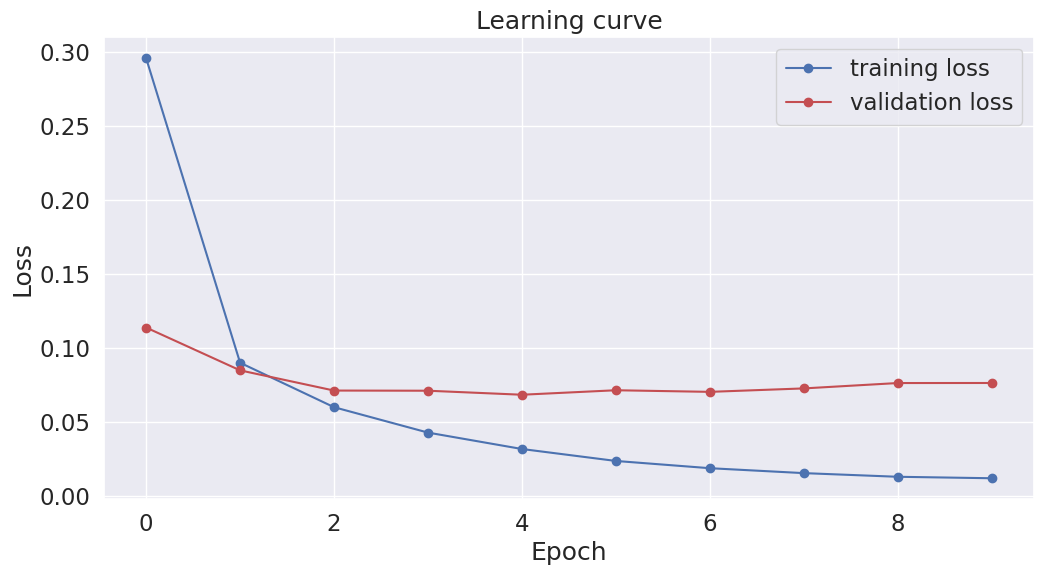

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [38]:
test_sentence = """
In October 2022, we identified an active infection of government, agriculture\
 and transportation organizations located in the Donetsk, Lugansk, and Crimea regions. Although the initial vector of compromise is unclear, the details of the next stage imply the use of spear phishing or similar methods.\
 The victims navigated to a URL pointing to a ZIP archive hosted on a malicious web server.
 """

In [39]:
t = test_sentence.split()

In [40]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [41]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [42]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [43]:
for token, label in zip(new_tokens, new_labels):
  if token == '[CLS]' or token == '[SEP]':
    pass
  else:
    print("{:20}\t{}".format(token, label))

In                  	O
October             	B-DATE_TIME
2022                	I-DATE_TIME
,                   	O
we                  	O
identified          	O
an                  	O
active              	O
infection           	O
of                  	O
government          	B-IDENTITY
,                   	O
agriculture         	B-IDENTITY
and                 	O
transportation      	B-IDENTITY
organizations       	O
located             	O
in                  	O
the                 	O
Donetsk             	B-LOCATION
,                   	O
Lugansk             	B-LOCATION
,                   	O
and                 	O
Crimea              	B-LOCATION
regions             	O
.                   	O
Although            	O
the                 	O
initial             	O
vector              	O
of                  	O
compromise          	O
is                  	O
unclear             	O
,                   	O
the                 	O
details             	O
of                  	O
the                 	O
next  